In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, log_loss, plot_confusion_matrix, accuracy_score, f1_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [2]:
X_df = pd.read_csv("Training_set_values.csv")
y_df = pd.read_csv("Training_set_labels.csv")

X_submit = pd.read_csv("Test_set_values.csv")

In [3]:
train_df = pd.merge(y_df, X_df, how='inner', on='id')

In [4]:
train_df['status'] = train_df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})

In [5]:
train_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2


In [6]:
train_df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [7]:
train_df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [8]:
train_df = train_df.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward', 
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded',
                         'public_meeting',
                         'scheme_management'], axis=1)
                        

In [9]:
train_df = train_df.set_index('id')

In [10]:
num_dict = {}
dfp = train_df.copy().drop(['status_group', 'status'], axis =1)

for x in dfp.columns:
    if dfp[x].dtypes == 'object':
        num_dict[x] = len(dfp[x].value_counts())
num_dict
    

{'funder': 1897,
 'installer': 2145,
 'wpt_name': 37400,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'permit': 2,
 'extraction_type_group': 13,
 'management': 12,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_type': 7,
 'waterpoint_type_group': 6}

In [11]:
train_df = train_df.drop(['funder','installer','wpt_name','subvillage'], axis=1)

In [12]:
train_df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_group       0
management                  0
payment_type                0
quality_group               0
quantity_group              0
source_type                 0
waterpoint_type_group       0
status                      0
dtype: int64

In [13]:
train_df = train_df.dropna()

In [14]:
train_df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status                   0
dtype: int64

In [15]:
train_df['permit'] = train_df['permit'].astype(int)

In [16]:
X = train_df.drop(['status_group', 'status'], axis=1)
y = train_df['status']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56344 entries, 69572 to 26348
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   gps_height             56344 non-null  int64  
 2   longitude              56344 non-null  float64
 3   latitude               56344 non-null  float64
 4   basin                  56344 non-null  object 
 5   region                 56344 non-null  object 
 6   region_code            56344 non-null  int64  
 7   district_code          56344 non-null  int64  
 8   population             56344 non-null  int64  
 9   permit                 56344 non-null  int64  
 10  construction_year      56344 non-null  int64  
 11  extraction_type_group  56344 non-null  object 
 12  management             56344 non-null  object 
 13  payment_type           56344 non-null  object 
 14  quality_group          56344 non-null  object 
 15

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
X_train_ohe = X_train.select_dtypes('object')
X_train_ohe = pd.concat([X_train_ohe, X_train[['region_code', 'district_code']]], axis=1)
X_test_ohe = X_test.select_dtypes('object')
X_test_ohe = pd.concat([X_test_ohe, X_test[['region_code', 'district_code']]], axis=1)

ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
ohe.fit(X_train_ohe)
X_train_ohe_trans = ohe.transform(X_train_ohe)
X_test_ohe_trans = ohe.transform(X_test_ohe)

train_temp_df = pd.DataFrame(X_train_ohe_trans, columns=ohe.get_feature_names(), index=X_train.index)
test_temp_df = pd.DataFrame(X_test_ohe_trans, columns=ohe.get_feature_names(), index=X_test.index)

X_train_ss = X_train.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)
X_test_ss = X_test.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)

ss = StandardScaler()
ss.fit(X_train_ss)
X_train_scaled = ss.transform(X_train_ss)
X_test_scaled = ss.transform(X_test_ss)

train_temp_df1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train_ss.columns)
test_temp_df1 = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test_ss.columns)


train_temp_df2 = X_train[['permit']]
test_temp_df2 = X_test[['permit']]

X_train_clean = pd.concat([train_temp_df1, train_temp_df2, train_temp_df], axis=1)
X_test_clean = pd.concat([test_temp_df1, test_temp_df2, test_temp_df], axis=1)

In [46]:
X_train_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
51330,-0.120477,-0.563706,0.393281,-0.807837,0.700882,0.706150,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11533,-0.120477,-0.953440,-0.184709,0.481522,-0.389861,-1.373207,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12099,0.248646,1.289342,0.139725,-1.080540,-0.280787,0.739824,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46261,-0.120477,-0.953440,-5.092541,1.928660,-0.389861,-1.373207,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29786,-0.120477,0.943073,-0.531919,0.702178,0.700882,0.738771,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_test_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
64088,-0.120477,0.562032,0.259208,-1.603594,0.199140,0.732458,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73174,-0.120477,1.870321,0.067690,-1.201454,-0.324416,0.735615,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15337,-0.120477,1.616777,0.636472,0.359782,-0.387679,0.715621,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18641,-0.120477,1.954353,0.098412,-1.352260,-0.313509,0.736667,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17947,-0.120477,0.980742,0.370086,0.779454,-0.171712,0.744033,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
def model_score(model, X, y_predict, y_true):
    acc = accuracy_score(y_predict, y_true)
    rec = recall_score(y_predict, y_true, average='weighted')
    f1 = f1_score(y_predict, y_true, average='weighted')
    prec = precision_score(y_predict, y_true, average='weighted')
    cross = cross_val_score(estimator=model, X=X, y=y_true, cv=10).mean()
    
    print(f' The accuracy score is: {round(acc, 4)}')
    print(f' The cross validation score of accuracy is: {round(cross, 4)}')
    print(f' The recall score is: {round(rec, 4)}')
    print(f' The F1 score is: {round(f1, 4)}')
    print(f' The precision score is: {round(prec, 4)}')
    
    return plot_confusion_matrix(model, X, y_true);

0.4518590824385482


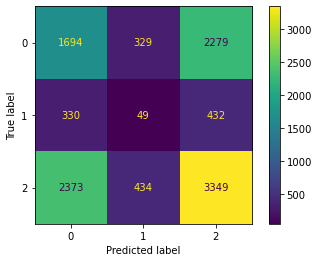

In [49]:
dummy = DummyClassifier(random_state=16)
dummy.fit(X_train_clean, y_train)
print(dummy.score(X_test_clean, y_test))

plot_confusion_matrix(dummy, X_test_clean, y_test);

Training data model score:
 The accuracy score is: 0.7413
 The cross validation score of accuracy is: 0.74
 The recall score is: 0.7413
 The F1 score is: 0.7667
 The precision score is: 0.8114


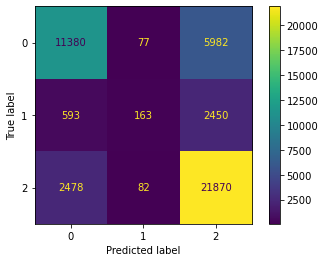

In [50]:
log_model = LogisticRegression(multi_class = "multinomial")
log_model.fit(X_train_clean, y_train)
log_y_pred_train = log_model.predict(X_train_clean)

print("Training data model score:")
log_train_score = model_score(log_model, X_train_clean, log_y_pred_train, y_train)

In [51]:
import statsmodels.api as sm

log_reg = sm.GLM(y_train, X_train_clean).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                45075
Model:                            GLM   Df Residuals:                    44961
Model Family:                Gaussian   Df Model:                          113
Link Function:               identity   Scale:                         0.58875
Method:                          IRLS   Log-Likelihood:                -51954.
Date:                Wed, 08 Dec 2021   Deviance:                       26462.
Time:                        14:39:27   Pearson chi2:                 2.65e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
amount_tsh                     0.0120      0.004      3.179      0.001       0.005       0.019
gps_height                     0.0311      0.011      2.926      0.003       0.010       0.052
longitude                     -0.0111      0.008     -1.471      0.141      -0.026       0.004
latitude                       0.0273      0.030      0.911      0.362      -0.031       0.086
population                     0.0268      0.004      6.771      0.000       0.019       0.035
construction_year              0.0071      0.012      0.585      0.559      -0.017       0.031
permit                         0.1355      0.010     13.140      0.000       0.115       0.156
x0_Lake Nyasa                  0.4133      0.041      9.992      0.000       0.332       0.494
x0_Lake Rukwa                 -0.0767      0.037     -2.054      0.040      -0.150      -0.004
x0_Lake Tanganyika             0.0166      0.026      0.633      0.527      -0.035       0.068
x0_Lake Victoria               0.0351      0.027      1.297      0.194      -0.018       0.088
x0_Pangani                    -0.1480      0.029     -5.142      0.000      -0.204      -0.092
x0_Rufiji                      0.1361      0.034      3.956      0.000       0.069       0.204
x0_Ruvuma / Southern Coast     0.2979      0.051      5.890      0.000       0.199       0.397
x0_Wami / Ruvu                 0.0134      0.031      0.433      0.665      -0.047       0.074
x1_Dar es Salaam           -3.522e+10   2.73e+10     -1.288      0.198   -8.88e+10    1.84e+10
x1_Dodoma                     -0.4663      0.217     -2.154      0.031      -0.891      -0.042
x1_Iringa                   9.057e+10   7.03e+10      1.288      0.198   -4.73e+10    2.28e+11
x1_Kagera                   6.204e+10   4.82e+10      1.288      0.198   -3.24e+10    1.56e+11
x1_Kigoma                   8.678e+10   6.74e+10      1.288      0.198   -4.53e+10    2.19e+11
x1_Kilimanjaro             -8.009e+10   6.22e+10     -1.288      0.198   -2.02e+11    4.18e+10
x1_Lindi                    6.204e+10   4.82e+10      1.288      0.198   -3.24e+10    1.56e+11
x1_Manyara                  5.515e+10   4.28e+10      1.288      0.198   -2.88e+10    1.39e+11
x1_Mara                     9.827e+10   7.63e+10      1.288      0.198   -5.13e+10    2.48e+11
x1_Mbeya                    1.274e+11   9.89e+10      1.288      0.198   -6.65e+10    3.21e+11
x1_Morogoro                -1.473e+10   1.14e+10     -1.288      0.198   -3.71e+10    7.69e+09
x1_Mtwara                  -2.654e+10   2.06e+10     -1.288      0.198   -6.69e+10    1.38e+10
x1_Mwanza                   9.057e+10   7.03e+10      1.288      0.198   -4.73e+10    2.28e+11
x1_Pwani                        2e+10   1.55e+10      1.288      0.198   -1.04e+10    5.04e+10
x1_Rukwa                   -1.421e+11    1.